# Предсказание для сегмента цепи; PyTorch. 

# METHOD: Neural Networks (PyTorch)

# DATA: side-chain-multiple-data-extended_no_padding

# SUPPLEMENTARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import Bio.PDB as pdb
import json

## 1. Data Init

### 1.1. Data paths and names

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = 'drive/MyDrive/Colab Notebooks/side-chain-multiple-data-extended_no_padding.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!ls

drive  __MACOSX  sample_data  side-chain-multiple-data-extended_no_padding


In [ ]:
with open("./side-chain-multiple-data-extended_no_padding/filenames.json") as f:
    filenames = json.loads(f.read())
BATCH_SIZE = 128 #

In [ ]:
print('Train:=', len(filenames['train']))
print('Test:=', len(filenames['test']))
print('Validation:=', len(filenames['validation']))

Train:= 50130
Test:= 21511
Validation:= 10003


In [ ]:
from torch.nn import LSTM, Conv2d, Linear, Dropout, Sequential, Module, MaxPool2d, AvgPool2d, Flatten, BCELoss, Sigmoid, ReLU, Dropout2d, Dropout
from torch import cat, Tensor, reshape
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch

## 2. Sample Generator

In [ ]:
class ProteinGenerator(Dataset):
    def __init__(self, filenames, transpose=False):
        self._transpose = transpose
        self.filenames = filenames
        self.batch_size = 1
    
    def __len__(self):
        return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx):
        filenames = self.filenames[idx * self.batch_size:(idx+1) * self.batch_size]
        batch_x = np.array([np.load(name.replace("*", "x")) for name in filenames])
        batch_x = batch_x[0]
        batch_y = np.array([np.load(name.replace("*", "y")) for name in filenames])
        batch_y = batch_y[0]
        if self._transpose:
            batch_x = np.swapaxes(batch_x, 0, 1)
        return Tensor(np.swapaxes(np.swapaxes(batch_x, 0, 1), 0, 2)), Tensor(batch_y)

## 3. NN Structure class

In [ ]:
class NNConfig:
    def __init__(self, 
                 md, 
                 train_samp_gntr, 
                 test_samp_gntr,
                 loss_func,
                 optimizer,
                 n_epochs,
                 device = None):
        """
        :param md: torch.nn.Module subclass;
        :param train_samp_gntr: torch.utils.data.DataLoader subclass with train data;
        :param test_samp_gntr: torch.utils.data.DataLoader subclass with test data;
        :param loss_func: Loss function taken from torch.nn;
        :param optimizer: Optimizer taken from torch.optim;
        :param n_epochs: number of epochs to perform
        """
        self.md = md
        self.train_samp_gntr = train_samp_gntr
        self.test_samp_gntr = test_samp_gntr
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.device = device
    
    def fit(self, verbose=False, use_tqdm=False):
        epoch_range = range(self.n_epochs)
        batch_range = enumerate(self.train_samp_gntr)
        if use_tqdm:
            if "ZMQ" in get_ipython().__class__.__name__:
                from tqdm.notebook import tqdm
            else:
                from tqdm import tqdm
            epoch_range = tqdm(epoch_range)
            batch_range = tqdm(batch_range)
        self.md.train()#
        for epoch_ind in epoch_range:
            if verbose:
                print(f"epoch {epoch_ind} started")
            for i, (X, y) in batch_range:
                if self.device:
                    X = X.to(self.device)
                    y = y.to(self.device)
                self.optimizer.zero_grad()#
                y_pred = self.md(X)
                pred_loss = self.loss_func(y_pred, y)
                pred_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.md.parameters(), 1)#
                self.optimizer.step()
                if i % 10 == 0:
                    print("\tEpoch {}, Step {}. Loss: {}".format(epoch_ind, i, pred_loss.item()))
                    
                   
                    
    def predict(self, tr=False, X=None):
        """
        :param X: input to make prediction. If None, make prediction to all test samples.
        """
        self.md.eval()
        prediction = []

        if X == None:
            with open("./side-chain-multiple-data-extended_no_padding/filenames.json") as f:
                filenames = json.loads(f.read())
            test_set = ProteinGenerator(filenames["test"], transpose=tr)
            X = DataLoader(test_set, batch_size=1, shuffle=False)
        with torch.no_grad():
            for x, _ in X:
                if self.device:
                    x = x.to(self.device)
                pred = self.md(x)
                prediction.append(pred)
        return prediction

# STRUCTURE DEFINITION

In [ ]:
structures = []

In [ ]:
import torch
torch.cuda.is_available()

True

### 1. input -> Conv2D -> Conv2D ->  Conv2D -> output

In [ ]:
class Net1_cnn(Module): #CNN 3
    def __init__(self):
        super().__init__()

        self.conv1 = Conv2d(1, 128, kernel_size=3)
        self.act1 = ReLU()
        self.pool1 = MaxPool2d(kernel_size=(2,2))
        self.conv2 = Conv2d(128, 100, kernel_size=3)
        self.act2 = ReLU()
        self.conv3 = Conv2d(100, 64, kernel_size=3)
        self.act3 = ReLU()
        self.flatten = Flatten(start_dim=2)
        self.lin1 = Linear(in_features=2538, out_features=36)
        self.out_activation = Sigmoid()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.act3(out)
        out = self.flatten(out)
        out = self.lin1(out)
        out = self.out_activation(out)
        return out

In [ ]:
train_set = ProteinGenerator(filenames["train"], transpose=False)
train_generator = DataLoader(train_set, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True)

In [ ]:
structures = []
md1 = Net1_cnn()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
md1.to(device)
loss_func = BCELoss()
optimizer = Adam(md1.parameters())
structures += [NNConfig(md1, train_generator, None, loss_func, optimizer, 1, device=device)]

In [ ]:
pred = structures[0].predict(tr=False)

In [ ]:
accs = []
test_generator = ProteinGenerator(filenames["test"], transpose=True)
for i in range(len(test_generator)):
    x,y_true = test_generator[i]
    y_pred = pred[i]
    accs.append(rotamer_accuracy_2(y_pred.cpu(), y_true, rotamer_bin_radius=3))


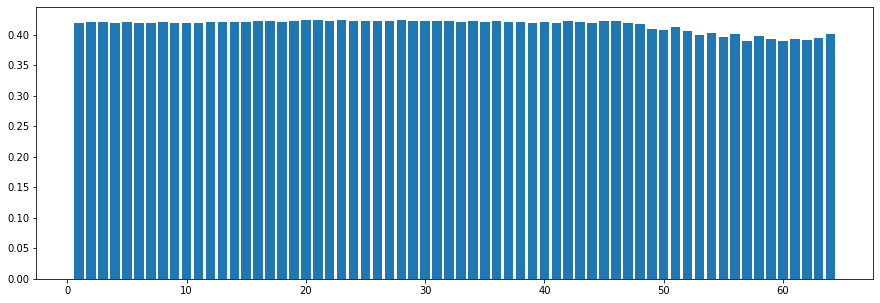

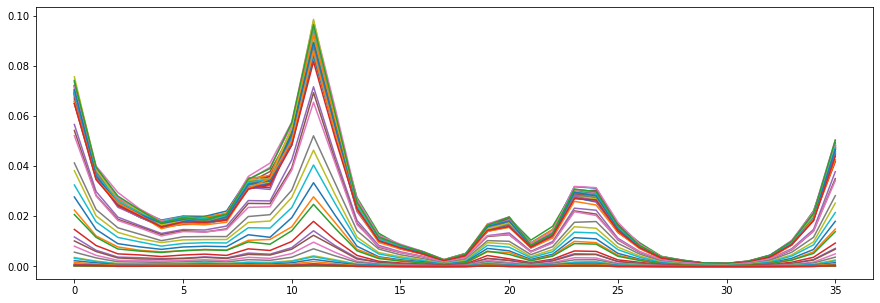

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(1, 65), np.nansum(accs, axis=0)  / np.count_nonzero(~np.isnan(accs), axis=0))
# plt.savefig("accs_nans.png")
plt.show()
plt.figure(figsize=(15,5))
for i in range(64):
    plt.plot(np.arange(0, 36), pred[0][0][i].cpu())
plt.show()

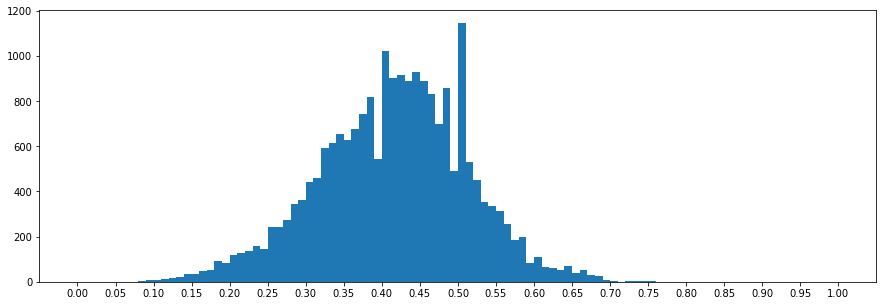

In [ ]:
accs_2 = []  ###
test_generator = ProteinGenerator(filenames["test"], transpose=False)
for i in range(len(test_generator)):
    x,y_true = test_generator[i]
    y_pred = pred[i]
    accs_2.append(rotamer_accuracy(y_pred.cpu(), y_true, rotamer_bin_radius=3))

    # extended with rad 3

plt.figure(figsize=(15,5))
plt.hist(accs_2, bins=100, range=(0,1))
plt.xticks(np.arange(0,1.05,0.05))
plt.savefig("accs_bn.png")
plt.show()

In [ ]:
def rotamer_accuracy(y_pred, y_true, rotamer_bin_radius=3):
    if len(y_pred.shape) > 2:
        y_pred = np.reshape(y_pred, (y_pred.shape[-2], y_pred.shape[-1]))
    if len(y_true.shape) > 2:
        y_true = np.reshape(y_true, (y_true.shape[-2], y_true.shape[-1]))
    
    pred_bins = np.argmax(y_pred, axis=1)
    orig_bins = np.argmax(y_true, axis=1)
    dists = np.abs(pred_bins - orig_bins)
    # print(dists)
    dists = np.minimum(dists, 36 - dists)
    chi_present_mask = np.max(y_true.numpy(), axis=1) > 0
#     print(chi_present_mask)
    dists = dists[chi_present_mask].numpy()
    
    
    return np.sum(dists <= rotamer_bin_radius) / dists.shape[0]

In [ ]:
def rotamer_accuracy_2(y_pred, y_true, rotamer_bin_radius=3):
    if len(y_pred.shape) > 2:
        y_pred = np.reshape(y_pred, (y_pred.shape[-2], y_pred.shape[-1]))
    if len(y_true.shape) > 2:
        y_true = np.reshape(y_true, (y_true.shape[-2], y_true.shape[-1]))
    
    pred_bins = np.argmax(y_pred, axis=1)
    orig_bins = np.argmax(y_true, axis=1)
    dists = np.abs(pred_bins - orig_bins)
    dists = np.minimum(dists, 36 - dists)
    y_true = y_true.numpy()
    chi_present_mask = np.max(y_true, axis=1) > 0 # 
    result = []
    for i in range(chi_present_mask.shape[0]):
        if chi_present_mask[i] == False:
            result.append(np.nan)
        else:
            if  (dists <= rotamer_bin_radius)[i] == True:
                result.append(1)
            else:
                result.append(0)
    return result

In [ ]:
from tqdm import tqdm

## 2. input -> Conv2D -> LSTM -> Linear -> output

In [ ]:
class Net2(Module):
    def __init__(self):
        super().__init__()
        self.dropouts = []
        
        self.conv1 = Conv2d(1, 64, kernel_size=3, stride=3)
        self.dropouts += [Dropout2d(p=0.5)]
        self.act1 = ReLU()
        self.pool1 = MaxPool2d(kernel_size=(2,2), stride=2)
        self.lstm = LSTM(input_size=330, hidden_size=330)
        self.dropouts += [Dropout2d(p=0.5)]
        self.act2 = ReLU()
        self.flatten = Flatten(start_dim=2)
        self.dropouts += [Dropout(p=0.5)]
        self.lin1 = Linear(in_features=330, out_features=256)
        self.dropouts += [Dropout(p=0.5)]
        self.lin2 = Linear(in_features=256, out_features=64)
        self.dropouts += [Dropout(p=0.5)]
        self.lin3 = Linear(in_features=64, out_features=36)
        self.out_activation = Sigmoid()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.dropouts[0](out)
        out = self.act1(out)
        out = self.pool1(out)
        out = reshape(out, (out.shape[0], out.shape[1], -1))
        out = self.lstm(out)[0]
        out = self.dropouts[1](out)
        out = self.act2(out)
        out = self.flatten(out)
        out = self.dropouts[2](out)
        out = self.lin1(out)
        out = self.dropouts[3](out)
        out = self.lin2(out)
        out = self.dropouts[4](out)
        out = self.lin3(out)
        out = self.out_activation(out)
        return out

In [ ]:
train_set = ProteinGenerator(filenames["train"], transpose=False)
train_generator = DataLoader(train_set, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True)

In [ ]:
md2 = Net2()
loss_func = BCELoss()
optimizer = Adam(md2.parameters())

In [ ]:
md2.to(device)

Net2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(3, 3))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(330, 330)
  (act2): ReLU()
  (flatten): Flatten(start_dim=2, end_dim=-1)
  (lin1): Linear(in_features=330, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=36, bias=True)
  (out_activation): Sigmoid()
)

In [ ]:
structures += [NNConfig(md2, train_generator, None, loss_func, optimizer, 1, device =device)]

In [ ]:
structures[-1]

In [2]:
structures[-1].fit(use_tqdm=True)

In [ ]:
pred = structures[-1].predict(tr=False)

In [ ]:
accs = []  ###
test_generator = ProteinGenerator(filenames["test"], transpose=False)
for i in range(len(test_generator)):
    x,y_true = test_generator[i]
    y_pred = pred[i]
    accs.append(rotamer_accuracy_2(y_pred.cpu(), y_true, rotamer_bin_radius=3))


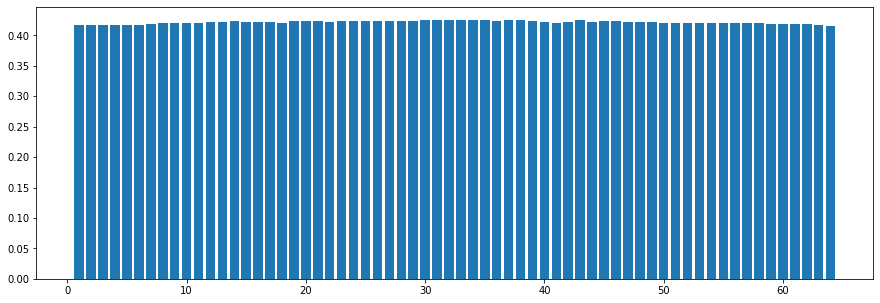

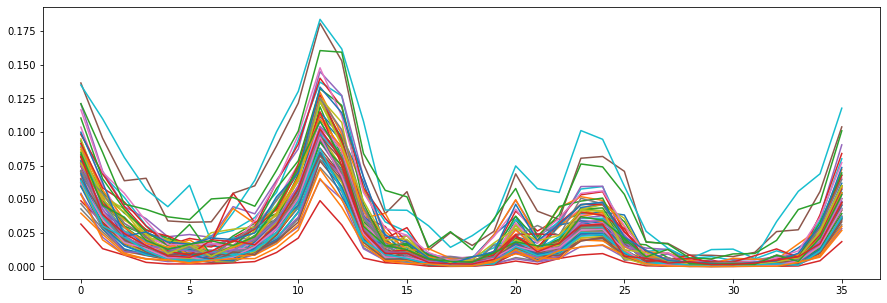

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(1, 65), np.nansum(accs, axis=0)  / np.count_nonzero(~np.isnan(accs), axis=0))
# plt.savefig("accs_nans.png")
plt.show()
plt.figure(figsize=(15,5))
for i in range(64):
    plt.plot(np.arange(0, 36), pred[0][0][i].cpu())
plt.show()

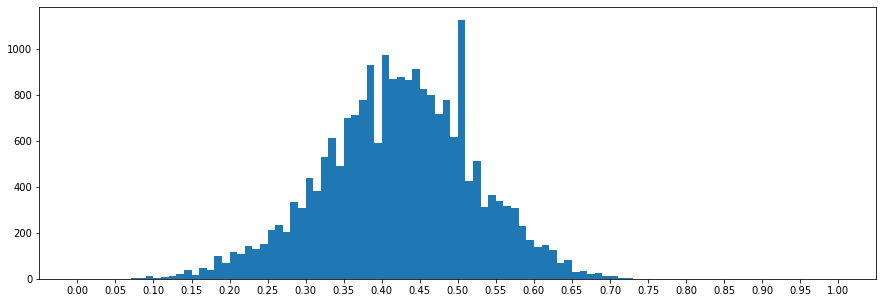

In [ ]:
accs_2 = []  ###
test_generator = ProteinGenerator(filenames["test"], transpose=False)
for i in range(len(test_generator)):
    x,y_true = test_generator[i]
    y_pred = pred[i]
    accs_2.append(rotamer_accuracy(y_pred.cpu(), y_true, rotamer_bin_radius=3))

    # extended with rad 3

plt.figure(figsize=(15,5))
plt.hist(accs_2, bins=100, range=(0,1))
plt.xticks(np.arange(0,1.05,0.05))
plt.savefig("accs_bn.png")
plt.show()

# ResNet

In [ ]:
from torch import nn

In [ ]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.num_layers = num_layers
        self.expansion = 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        super(ResNet, self).__init__()
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=256, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=1024, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=2560, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(40 * self.expansion, num_classes)
        self.act_out = Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = x.reshape(x.shape[0], 64, 40)
        x = self.fc(x)
        x = self.act_out(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [ ]:
model = ResNet(18, Block, 1, 36)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model_res.pth'))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
loss_func = BCELoss()
optimizer = Adam(model.parameters())
model.to(device)
print(1)

1


In [ ]:
train_set = ProteinGenerator(filenames["train"], transpose=False)
train_generator = DataLoader(train_set, 
                             batch_size=256, 
                             shuffle=True)

In [ ]:
net = NNConfig(model, train_generator, None, loss_func, optimizer, 1, device)

In [1]:
net.fit(use_tqdm=True)

In [ ]:
pred = net.predict(tr=False)

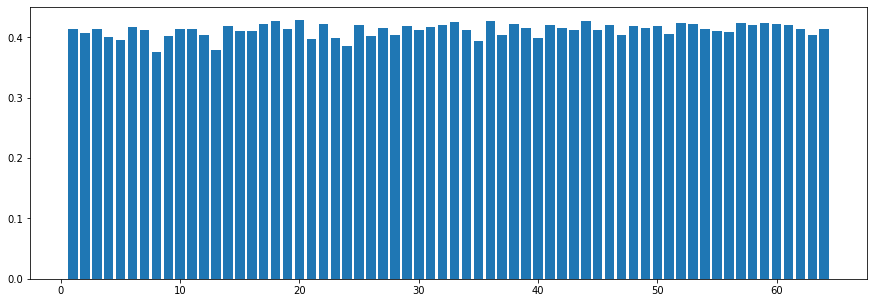

In [ ]:
pred = net.predict(tr=False)
accs = []
test_generator = ProteinGenerator(filenames["test"], transpose=False)
for i in range(len(test_generator)):
    x,y_true = test_generator[i]
    y_pred = pred[i]
    accs.append(rotamer_accuracy_2(y_pred.cpu(), y_true, rotamer_bin_radius=3))

plt.figure(figsize=(15,5))
plt.bar(np.arange(1, 65), np.nansum(accs, axis=0)  / np.count_nonzero(~np.isnan(accs), axis=0))
# plt.savefig("accs_nans.png") 
plt.show()

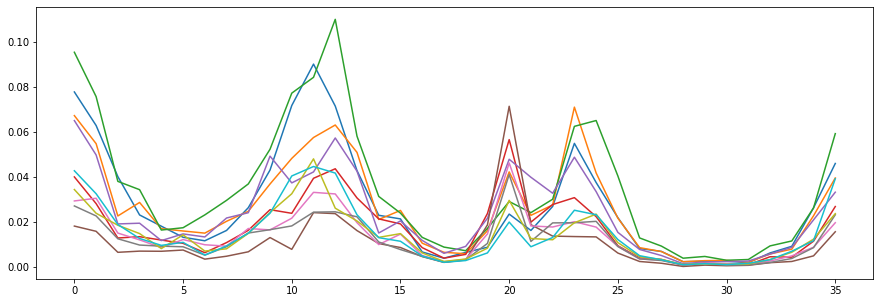

In [ ]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(np.arange(0, 36), pred[0][0][i].cpu())
plt.show()

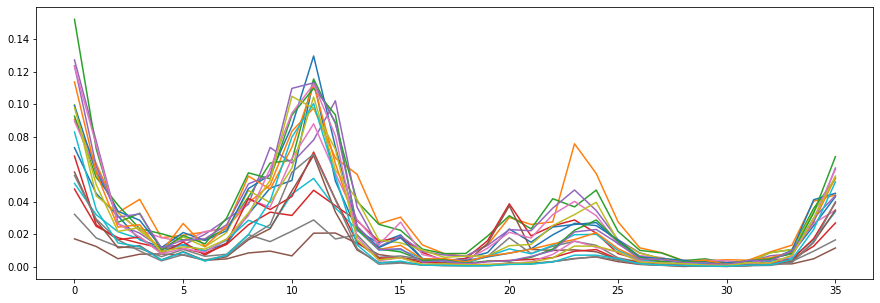

In [ ]:
plt.figure(figsize=(15,5))
for i in range(20):
    plt.plot(np.arange(0, 36), pred[57][0][i].cpu())
plt.show()

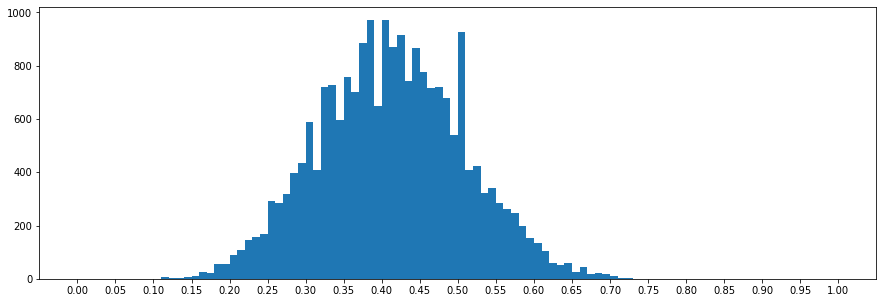

In [ ]:
accs_2 = []  ###
test_generator = ProteinGenerator(filenames["test"], transpose=False)
for i in range(len(test_generator)):
    x,y_true = test_generator[i]
    y_pred = pred[i]
    accs_2.append(rotamer_accuracy(y_pred.cpu(), y_true, rotamer_bin_radius=3))

    # extended with rad 3

plt.figure(figsize=(15,5))
plt.hist(accs_2, bins=100, range=(0,1))
plt.xticks(np.arange(0,1.05,0.05))
plt.savefig("accs_bn.png")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_res.pth')